# Classification
From our [feature-selection notebook](Features.ipynb)) it seems we should be able to make some statements about crime taxonomy related indicators based on the incident time and location. However, this domain is tricky for formulating a right classification problem: all potential targets seem converge to the same areas (areas where most of violent crime incidents occur often are the same areas where most of non-violent incidents occur). Predicting crime category based on time and location wouldn't make a lot of sense: predicting probability would. We can look in crime categories probability distribution based on time and location (difference in "spectrum"); or, we can look at probability distribution of each indicator/category separately. (We still can use the same machinery, though; and [feature importance estimation](Features.ipynb) is still valid.)

In [1]:
import os
import re
import time
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load features
data = pd.read_csv('data/features.csv')
data.head()

,Unnamed: 0,stat,category,date,year,month,day,weekday,hour,city,zip,lng,lat,gang,violent,weapon,gun,knife
0,0,146,assault,2007-01-01,2007,1,1,0,0.416667,Whittier,90604,-117.993988,33.919049,0,1,0,0,0
1,1,153,weapon,2007-01-01,2007,1,1,0,0.166667,Littlerock,93543,-117.957799,34.557890,0,0,1,1,0
2,2,144,assault,2007-01-01,2007,1,1,0,0.083333,Universal City,91608,-118.351299,34.136272,0,1,0,0,0
3,3,340,theft,2007-01-01,2007,1,1,0,0.016667,San Gabriel,91775,-118.084600,34.117196,0,0,0,0,0
4,4,50,assault,2007-01-01,2007,1,1,0,1.539722,Rosemead,91770,-118.082102,34.040848,0,1,0,0,0


Let us drop weapon-lows category as it could be misleading for our goals here (see [crime-taxonomy notebook](Taxonomy.ipynb)). We have more relevant `weapon` indicator set (column).

In [3]:
data = data[~(data['category'] == 'weapon')]

In [4]:
data.shape

(1215725, 18)

In [5]:
data.iloc[:,1:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stat,1215725.0,181.263351,116.352081,11.00000,89.000000,146.000000,264.000000,511.000000
year,1215725.0,2011.353691,2.903285,2007.00000,2009.000000,2011.000000,2014.000000,2016.000000
month,1215725.0,6.446307,3.405913,1.00000,4.000000,6.000000,9.000000,12.000000
day,1215725.0,15.686646,8.795327,1.00000,8.000000,16.000000,23.000000,31.000000
weekday,1215725.0,2.975411,1.970044,0.00000,1.000000,3.000000,5.000000,6.000000
hour,1215725.0,13.037504,6.863167,0.00000,8.083333,14.000000,18.700000,23.999167
zip,1215725.0,91109.571820,1126.300542,90001.00000,90222.000000,90706.000000,91744.000000,98034.000000
lng,1215725.0,-118.186781,0.179500,-118.98837,-118.263541,-118.164993,-118.082199,-116.170000
lat,1215725.0,34.089818,0.264329,32.55000,33.903825,33.997014,34.138207,34.970000
gang,1215725.0,0.037765,0.190628,0.00000,0.000000,0.000000,0.000000,1.000000


We are not concerned with specifics of non-violent crime here.

In [6]:
data.loc[data['violent'] == 0, 'category'] = 'non-violent' 
data.groupby('category').size()

category
arson            5257
assault        203623
burglary        80652
family           8422
felonies          715
homicide         1908
non-violent    791675
rape             4468
robbery         48400
vandalism       68897
vehicle          1708
dtype: int64

We've got highly imbalanced representation. We might consider undersampling the less interesting "non-violent" category to match the most populated interesting "assault" category. For the rest (less populated but interesting) categories we might consider oversampling (resample with replacement).

In [7]:
category = data.groupby(['category']).size().reset_index(name = 'count').sort_values('count', ascending = False)
violent = data.groupby(['violent']).size().reset_index(name = 'count').sort_values('count', ascending = False)
weapon = data.groupby(['weapon']).size().reset_index(name = 'count').sort_values('count', ascending = False)
gang = data.groupby(['gang']).size().reset_index(name = 'count').sort_values('count', ascending = False)

# lookup counts for resampling
category = { category['category'].tolist()[i]:category['count'].tolist()[i] for i in range(len(category)) }
violent = { violent['violent'].tolist()[i]:violent['count'].tolist()[i] for i in range(2) }
weapon = { weapon['weapon'].tolist()[i]:weapon['count'].tolist()[i] for i in range(2) }
gang = { gang['gang'].tolist()[i]:gang['count'].tolist()[i] for i in range(2) }
violent

{0: 791675, 1: 424050}

As seen above our non-violent count is twice its more interesting counterpart, we just drop it equal.

In [8]:
# balance violent indicator representaion
sample = np.random.choice(violent[0], violent[1], replace = False)
reduced = data[data['violent'] == 0].reset_index().iloc[sample]
data = data[data['violent'] == 1].append(reduced, ignore_index = True)
violent = data # just a ref
violent.groupby('category').size()

category
arson            5257
assault        203623
burglary        80652
family           8422
felonies          715
homicide         1908
non-violent    424050
rape             4468
robbery         48400
vandalism       68897
vehicle          1708
dtype: int64

Let us create additional continuous temporal feature `timeline` to retain the infomation of categorical `year` (capture non-seasonal trend) and drop `year` (see [feature-selection notebook](Fetures.ipynb)). We going to keep continuous `hour` as new `time` feature and convert `hour` to categorical format.

In [9]:
# continuous version for temporal features combined
start = time.mktime(datetime.strptime('2007-01-01', '%Y-%m-%d').timetuple())
stop = time.mktime(datetime.strptime('2017-01-01', '%Y-%m-%d').timetuple())
data['timeline'] = data.apply(lambda r: \
    (time.mktime(datetime.strptime(r['date'],'%Y-%m-%d').timetuple()) + r['hour'] - start)/(stop - start), axis = 1)

# categorical version of `hour`
data['time'] = data['hour'].tolist()
data['hour'] = data['hour'].apply(lambda x: int(x))

data['timeline'].describe()

count    8.481000e+05
mean     4.847451e-01
std      2.927693e-01
min      5.280620e-11
25%      2.241879e-01
50%      4.798682e-01
75%      7.380121e-01
max      9.997263e-01
Name: timeline, dtype: float64

For categorical type our `zip` feature has a lot of options. As zipcodes of close numerical value tend to lump together we might get better use of this feature in its numeric format.

In [10]:
data['zip'] = data['zip'].apply(lambda x: float(x)/99999)

### 1. Preprocessing

In [11]:
city = LabelEncoder()
city.fit(data['city'].tolist())
data['city'] = city.transform(data['city'])

Let us generate balanced sets for `gang` and `weapon` indicators as well.

In [12]:
print(gang)

{0: 1169813, 1: 45912}


In [13]:
gang = data[(data['gang'] == 1)]
other = data[(data['gang'] == 0)]
sample = np.random.choice(len(other), len(gang), replace = False)
reduced = other.reset_index().iloc[sample]
gang = gang.append(reduced, ignore_index = True)
gang.groupby('category').size()

category
arson            264
assault        23361
burglary        4441
family           610
felonies          56
homicide        1102
non-violent    28882
rape             313
robbery         8391
vandalism       7304
vehicle           84
dtype: int64

In [14]:
print(weapon)

{0: 1176748, 1: 38977}


In [15]:
weapon = data[(data['weapon'] == 1)]
other = data[(data['weapon'] == 0)]
sample = np.random.choice(len(other), len(weapon), replace = False)
reduced = other.reset_index().iloc[sample]
weapon = weapon.append(reduced, ignore_index = True)
weapon.groupby('category').size()

category
arson            291
assault        26842
burglary        3951
family           409
felonies          29
homicide          91
non-violent    20221
rape             232
robbery        22394
vandalism       3400
vehicle           94
dtype: int64

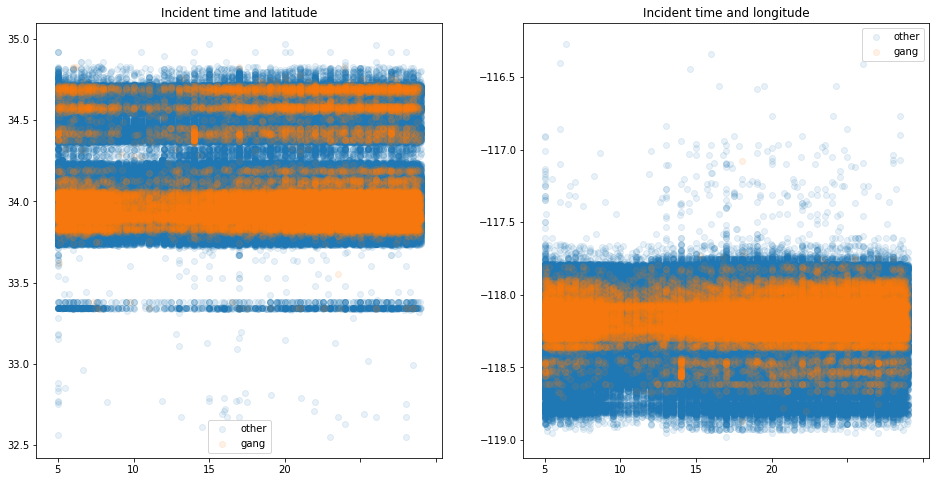

In [16]:
plt.rcParams['figure.figsize'] = (16, 8)
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax = ax.flatten()

ax[0].set_title('Incident time and latitude')
ax[0].set_xticklabels(range(0,25,5))
ax[1].set_title('Incident time and longitude')
ax[1].set_xticklabels(range(0,25,5))

for v in [0,1]:
    d = data[data['gang'] == v]
    label = 'gang' if v == 1 else 'other'
    ax[0].scatter(d['time'].values, d['lat'].values, alpha = 0.1, label = label)
    ax[1].scatter(d['time'].values, d['lng'].values, alpha = 0.1, label = label)

ax[0].legend()
ax[1].legend()
plt.show()

All the plots above show most variation happening along the axes and "nested" classes, predictors do not capture the information needed to make a separation, only the margins.

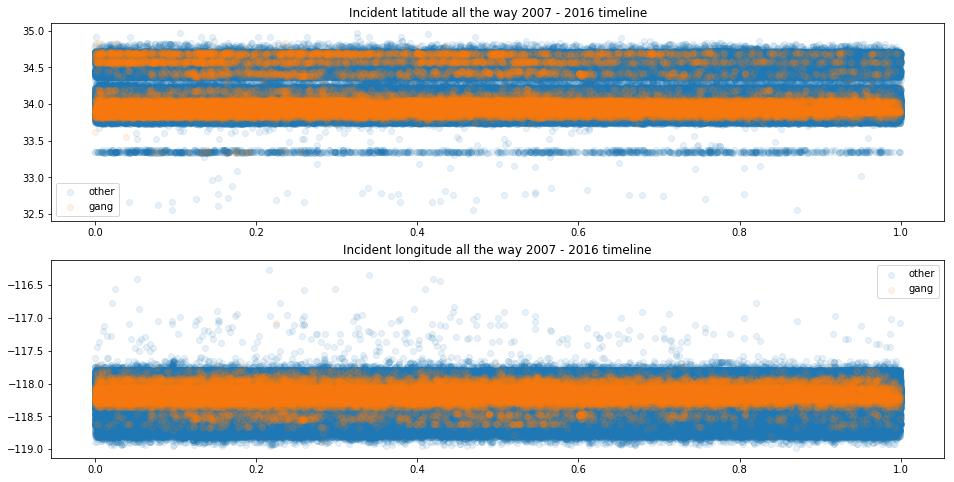

In [17]:
plt.rcParams['figure.figsize'] = (16, 8)
fig, ax = plt.subplots(nrows = 2, ncols = 1)
ax = ax.flatten()

ax[0].set_title('Incident latitude all the way 2007 - 2016 timeline')
ax[1].set_title('Incident longitude all the way 2007 - 2016 timeline')

for v in [0,1]:
    d = data[data['gang'] == v]
    label = 'gang' if v == 1 else 'other'
    ax[0].scatter(d['timeline'].values, d['lat'].values, alpha = 0.1, label = label)
    ax[1].scatter(d['timeline'].values, d['lng'].values, alpha = 0.1, label = label)

ax[0].legend()
ax[1].legend()
plt.show()

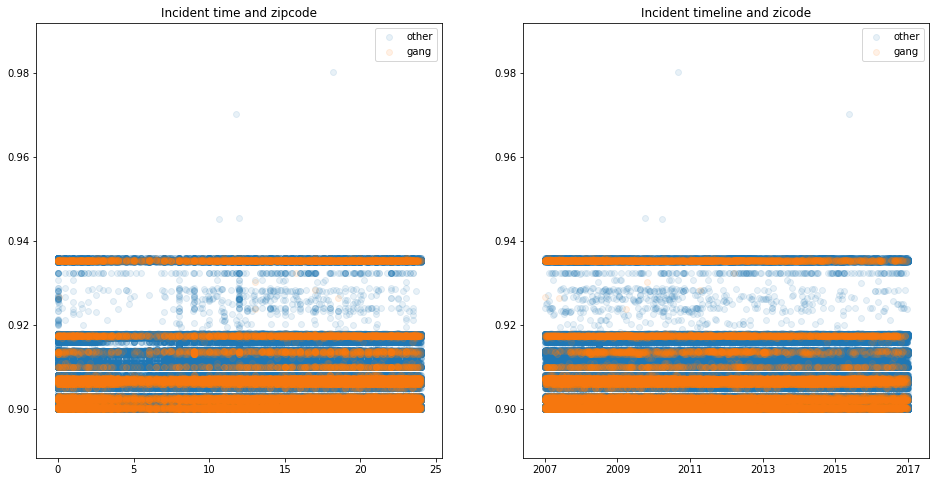

In [18]:
plt.rcParams['figure.figsize'] = (16, 8)
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax = ax.flatten()

ax[0].set_title('Incident time and zipcode')
ax[1].set_title('Incident timeline and zicode')
ax[1].set_xticklabels(range(2005,2018,2))

for v in [0,1]:
    d = data[data['gang'] == v]
    label = 'gang' if v == 1 else 'other'
    ax[0].scatter(d['time'].values, d['zip'].values, alpha = 0.1, label = label)
    ax[1].scatter(d['timeline'].values, d['zip'].values, alpha = 0.1, label = label)

ax[0].legend()
ax[1].legend()
plt.show()

In [19]:
continuous = ['timeline','time','lng','lat','zip']
categorical = ['hour','weekday','day','month','city']

In [20]:
def feature_prep(dataset, predictors, target, test_size = 0.3, random_state = None):
    """partitioned, scaled, and ready for the training"""
    
    X = dataset[predictors].as_matrix()
    Y = dataset[target].as_matrix()
    
    # split data for cross-validation
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = random_state)
    
    ind = [continuous.index(f) for f in predictors if f in continuous]
    if len(ind) > 0:   
        # subtract mean and divide by variance
        scaler = StandardScaler()

        X_train[:,:len(continuous)] = scaler.fit_transform(X_train[:,:len(continuous)])
        X_test[:,:len(continuous)] = scaler.transform(X_test[:,:len(continuous)])
        
    return X_train, X_test, Y_train, Y_test


### 2. Building model
Based on the plots above and before mentioned domain specifics our starter best shot is a decision trees ensemble.

In [21]:
def train_model(X, Y, n = 50, d = 20):
    """train random forest classifier"""

    model = RandomForestClassifier(n_estimators = n, max_depth = d, n_jobs = -1)
    model.fit(X, Y)

    prediction = model.predict(X)
    proba = [p[1] for p in model.predict_proba(X)]
    print('Train accuracy: {:.4f}'.format(accuracy_score(Y, prediction)))
    print('Predicted values: {} (make sure it does not always predict one class)'.format(np.unique(prediction)))
    return model    

In [22]:
def test_model(model, X, Y):
    """test model and show ROC curve"""

    prediction = model.predict(X)
    proba = [p[1] for p in model.predict_proba(X)]
    tn, fp, fn, tp = confusion_matrix(Y_test, prediction).ravel()
    print('ROC AUC: {:.4f}'.format(roc_auc_score(Y, proba)))
    print('Confusion matrix: TN:{} FP:{} FN:{} TP:{}'.format(tn, fp, fn, tp))
    fpr, tpr, thresholds = roc_curve(Y, prediction)
    roc_auc = auc(fpr, tpr)
    plt.rcParams['figure.figsize'] = (5,5)
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('R[eceiver] O[perating] C[haracteristic]')
    plt.legend(loc = 'lower right')
    plt.show()

In [23]:
# preparation
X_train, X_test, Y_train, Y_test = feature_prep(violent, continuous + categorical, 'violent')

In [24]:
# training
model = train_model(X_train, Y_train)

Train accuracy: 0.8497
Predicted values: [0 1] (make sure it does not always predict one class)


ROC AUC: 0.6681
Confusion matrix: TN:82342 FP:45039 FN:53183 TP:73866


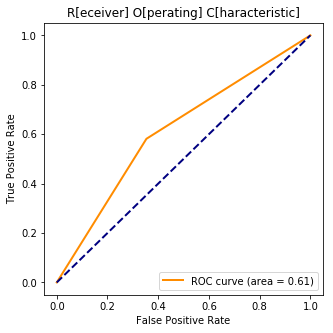

In [25]:
# evaluation
test_model(model, X_test, Y_test)

That's a coin flip quality predictor. Of course! The label outcome is not a right question to ask here. To validate this model we have to match the probability distribution it predicts. Still, we can use these `accuracy` metrics to tune up the model parameters.

In [26]:
def optimize_parameters(X_train, X_test, Y_train, Y_test):
    """grid search for best parameters"""
    
    params = []
    for n in range(50,101,10):
        for d in range(5,51,5):
            rf = RandomForestClassifier(n_estimators = n, max_depth = d, n_jobs = -1)
            rf.fit(X_train, Y_train)
            params.append([n, d, roc_auc_score(Y_test, [p[1] for p in rf.predict_proba(X_test)])])

    params = sorted(params, key = lambda x: x[2], reverse = True)
    for p in params[:5]:
        print('#estimators: {:<3} max depth: {}  model score: {:.4f}'.format(p[0], p[1], p[2]))            
            
    return params[0]

In [27]:
# we should really use another reserved partition here: not X_test, Y_test
n, d, s = optimize_parameters(X_train, X_test, Y_train, Y_test) 

#estimators: 100 max depth: 25  model score: 0.6725
#estimators: 100 max depth: 20  model score: 0.6722
#estimators: 90  max depth: 25  model score: 0.6719
#estimators: 90  max depth: 20  model score: 0.6715
#estimators: 80  max depth: 20  model score: 0.6712


Let's check our other sets.

Train accuracy: 0.9839
Predicted values: [0 1] (make sure it does not always predict one class)
ROC AUC: 0.6340
Confusion matrix: TN:6718 FP:4958 FN:4447 TP:7264


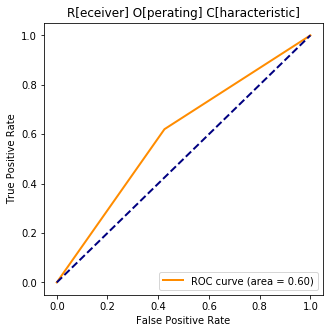

#estimators: 100 max depth: 15  model score: 0.6439
#estimators: 90  max depth: 15  model score: 0.6424
#estimators: 70  max depth: 15  model score: 0.6408
#estimators: 50  max depth: 15  model score: 0.6406
#estimators: 60  max depth: 15  model score: 0.6406


In [28]:
X_train, X_test, Y_train, Y_test = feature_prep(weapon, continuous + categorical, 'weapon')
model = train_model(X_train, Y_train)
test_model(model, X_test, Y_test)
n, d, s = optimize_parameters(X_train, X_test, Y_train, Y_test) 

Train accuracy: 0.9432
Predicted values: [0 1] (make sure it does not always predict one class)
ROC AUC: 0.7563
Confusion matrix: TN:6929 FP:4204 FN:2648 TP:8662


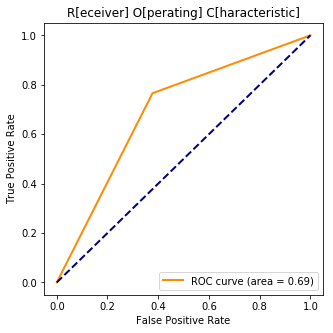

#estimators: 100 max depth: 15  model score: 0.7618
#estimators: 80  max depth: 15  model score: 0.7605
#estimators: 90  max depth: 15  model score: 0.7602
#estimators: 100 max depth: 20  model score: 0.7601
#estimators: 70  max depth: 15  model score: 0.7601


In [29]:
X_train, X_test, Y_train, Y_test = feature_prep(gang, continuous + categorical, 'gang')
model = train_model(X_train, Y_train)
test_model(model, X_test, Y_test)
n_opt, d_opt, s = optimize_parameters(X_train, X_test, Y_train, Y_test) 

### 3. Model validation

Train accuracy: 0.8479
Predicted values: [0 1] (make sure it does not always predict one class)


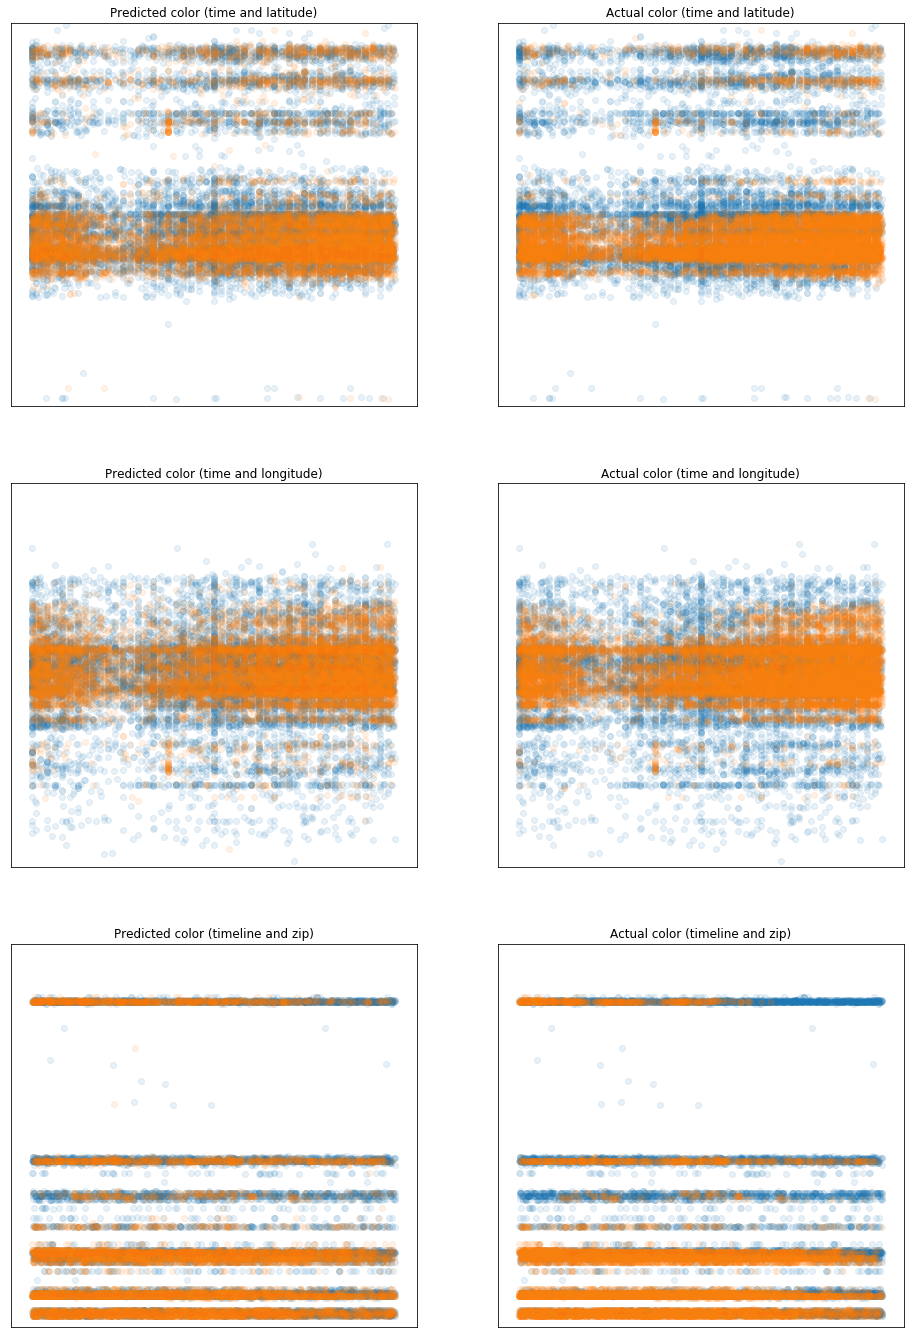

In [30]:
model = train_model(X_train, Y_train, n = n_opt, d = d_opt)
prediction = model.predict(X_test)

plt.rcParams['figure.figsize'] = (16, 24)
fig, ax = plt.subplots(nrows = 3, ncols = 2)
ax = ax.flatten()

ax[0].set_title('Predicted color (time and latitude)')
ax[0].set_ylim([-3,3])
ax[1].set_title('Actual color (time and latitude)')
ax[1].set_ylim([-3,3])
ax[2].set_title('Predicted color (time and longitude)')
ax[2].set_ylim([-5,5])
ax[3].set_title('Actual color (time and longitude)')
ax[3].set_ylim([-5,5])
ax[4].set_title('Predicted color (timeline and zip)')
ax[4].set_ylim([-1,3])
ax[5].set_title('Actual color (timeline and zip)')
ax[5].set_ylim([-1,3])

for i in range(6):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# index ref ['timeline','time','lng','lat','zip']
for v in [0,1]:
    P = X_test[Y_test == v]
    A = X_test[prediction == v]
    ax[0].scatter(P[:,1], P[:,3], alpha = 0.1)
    ax[1].scatter(A[:,1], A[:,3], alpha = 0.1)
    ax[2].scatter(P[:,1], P[:,2], alpha = 0.1)
    ax[3].scatter(A[:,1], A[:,2], alpha = 0.1)
    ax[4].scatter(P[:,0], P[:,4], alpha = 0.1)
    ax[5].scatter(A[:,0], A[:,4], alpha = 0.1)

plt.show()

Looks like the model is doing pretty well. The challenge is to check if it gives us the right ratio when there's an "overlap". We need to match predicted probability distribution, not just the most probable label. To do so let us try a trick: let us train a biased RF classifier on our test data, we need high accuracy (we don't care about overfitting here, we actually want it), so, we can use this classifier predicted probability output as our matching factor.

In [31]:
match = train_model(X_test, Y_test, n = 100, d = 100)

Train accuracy: 1.0000
Predicted values: [0 1] (make sure it does not always predict one class)


There we go. Now we can construct our probability distribution fitness metric:

In [32]:
n_classes = 2 # this will work the same for the arbitrary number of classes
n_observations = len(Y_test) # for multiclass: n_observations, n_classes = Y_test.shape
MSE = (((match.predict_proba(X_test) - model.predict_proba(X_test))) ** 2).sum() / n_observations / n_classes

# the value will fall between 0 and 1, closer to 1 is better
1 - MSE

0.916773511524306

Maybe our model is doing pretty good, after all. Not so much:

In [33]:
print('Mean difference in predicted probability value: {:.4f}'\
        .format(abs(match.predict_proba(X_test) - model.predict_proba(X_test)).sum()/n_observations/n_classes))

Mean difference in predicted probability value: 0.2523


For a good result we would expect this value to be much less than 0.5 (${1 \over n\_classes}$).